In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am
from utils import * 


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [31]:
L = 257
N = 10

p=0.34 # prob. of hopping in the same direction as the previous hop 
q=0.33

n = int(np.floor(np.log2(L)) - 1)

h = 0.24

filename = 'h_{}.dat'.format(h)
file = open(filename)
realisations, moments = read_file(file, verbose=True) 

#Parameters={ Seed: 5, Branching rate: 0.24, p : 0.34, q : 0.33, Realisations: 10, Chunk size: 10, Dimension: 2, (Max) Lattice size: 257, Graph Type: 0 }

#Version: #3ede

# Running for L = 257

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 

#Writing moments: 

# Info: count_full_resets=0 and count_cache_resets=10

#okely dokely!


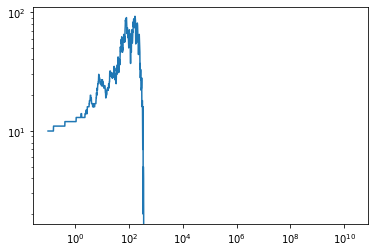

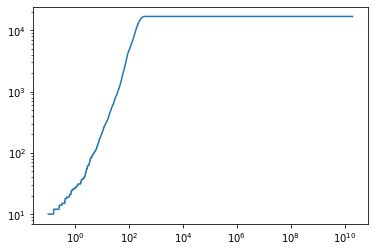

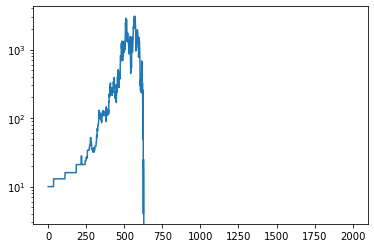

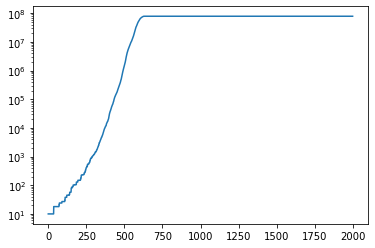

In [5]:
# print(moments)
active_moments, tracer_moments = extract_moments(moments)


plt.plot(active_moments[:, 0], active_moments[:, 2])
plt.yscale('log')
plt.xscale('log')
plt.show() 

plt.show() 

plt.plot(tracer_moments[:, 0], tracer_moments[:, 2])
plt.yscale('log')
plt.xscale('log')
plt.show() 

plt.plot(active_moments[:, 3])
plt.yscale('log')
plt.show() 

plt.plot(tracer_moments[:, 3])
plt.yscale('log')
plt.show() 

/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


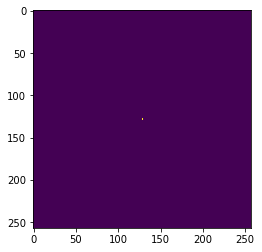

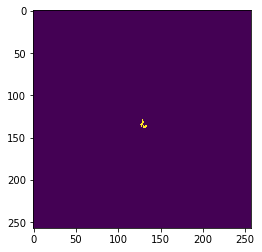

/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


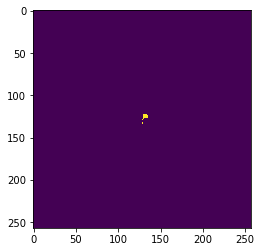

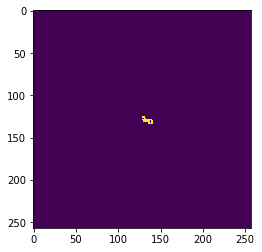

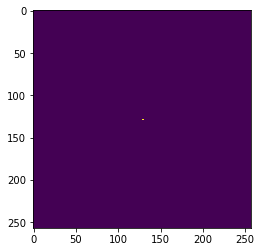

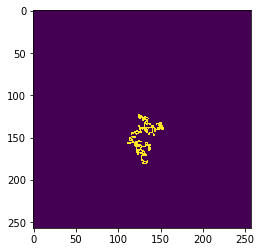

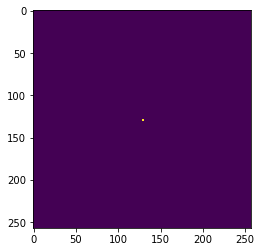

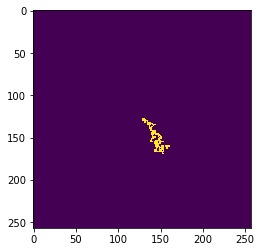

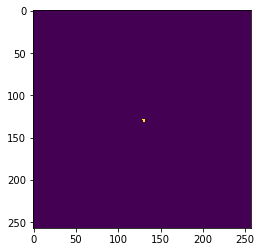

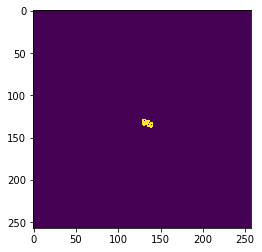

In [32]:
times = [] 
msds = [] 
tot_edge_reach = 0 
tot_possible_edge = len(realisations)*4 
binder = np.zeros((n))
tracers = [] 

for (i, realisation) in enumerate(realisations):

    t, edges, m, tracers, actives  = extract_evolution(realisation, 257)
    
    times.append(t)
    msds.append(m)
    
    plt.imshow(tracers[-1])
    plt.show() 
    
    

In [ ]:
# plot average msd vs time 
t = select_longest(times)[:-1] 
mean_msd = np.mean(pad(msds), axis=0)
plt.title('average msd')
plt.plot(t, mean_msd)
plt.yscale('log')
plt.xscale('log')
plt.show() 

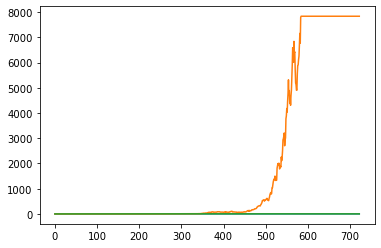

In [44]:
plt.plot(msds[])
plt.plot(msds[1])
plt.plot(msds[2])
plt.show() 